# Task 1 – Prediction: Water Stability from MOF Name

In this notebook, we demonstrate the ability of knowledge graph-augmented LLMs to predict material properties — specifically, water stability — based on MOF name alone.

By retrieving a few-shot set of similar MOFs and their known water stability labels from the knowledge graph, we provide the LLM with a context window grounded in experimental or literature-derived data. The model is then asked to predict the stability of a target MOF (from an external test set), using analogical reasoning from the retrieved examples.


## Getting Data From Knowledge Graph

In [1]:
from src.MOF_ChemUnity.Agents.QueryAgent import QueryGenerationAgent
from src.MOF_ChemUnity.utils.NeighbourFinder import NeighbourSearchAgent
import pandas as pd

In [2]:
# Get descriptors from graph
agent = QueryGenerationAgent()
desc_data = agent.run_full_query("Descriptors for all MOFs.")

✅ Connected to Neo4j.


,m.refcode,descriptor_name,descriptor_value
0,DUHDOA,Density,1.90203
1,KUNSUJ,Density,0.635531
2,OGIJIX,Density,2.2293
3,WOCKOP,Density,1.67685
4,CURYAQ,Density,1.90272
...,...,...,...
2662909,AMIWOJ,Largest_included_sphere_along_free_path,4.77757
2662910,AMIWUP,Largest_included_sphere_along_free_path,4.82312
2662911,AMIXAW,Largest_included_sphere_along_free_path,4.76214
2662912,AMIXEA,Largest_included_sphere_along_free_path,4.79308


In [3]:
# Get Water Stable MOFs
ws_data = agent.run_full_query("All MOFs that have a water stability value. Also return their MOFids")

,m.refcode,water_stability,MOFid
0,WOCKOP,Stable,C(Cc1ccncc1)Cc1ccncc1.[O-]C(=O)c1ccc(cc1)C(=O)...
1,UNABAN,Stable,"[O-]C(=O)C1CSCN1.[Zn] MOFid-v1.ERROR,UNKNOWN.c..."
2,UMUZUY,Stable,"[Ni].[O-]C(=O)C1CSCN1 MOFid-v1.UNKNOWN,sql.cat..."
3,IZOWAW,Unstable,O1[Mo]234O[Mo]56O[Mo]71[O]1[Zn]8[O]3[Mo]394[O]...
4,MESBAN,Unstable,[Ga].[O]P(=O)(CCP(=O)([O])[O])[O] MOFid-v1.UNK...
...,...,...,...
1797,IGUHAU,Stable,Nc1ncccn1.[Ag][Ag].[O-]C(=O)CCCC(=O)[O-] MOFid...
1798,TUGTAR,Unstable,[Cu].[Cu][OH][Cu][OH][Cu].n1ncn(c1)C12CC3CC(C1...
1799,QARNOO,Unstable,[Cu][Cu].[O-]C(=O)C.[Zn] MOFid-v1.ERROR.cat0;q...
1800,ULUKAN,Stable,O=C1C(=O)C(=O)C1=O.[OH2][Ni][OH2].n1ccc(cc1)c1...


## Initialize Nearest Neighbour Search

In [4]:
NeighbourSearch = NeighbourSearchAgent(desc_data) 

📐 Detected long-format descriptor data. Pivoting to wide format...


In [5]:
NeighbourSearch.embed_descriptors()

/home/tom-pruyn/miniconda3/envs/llms/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


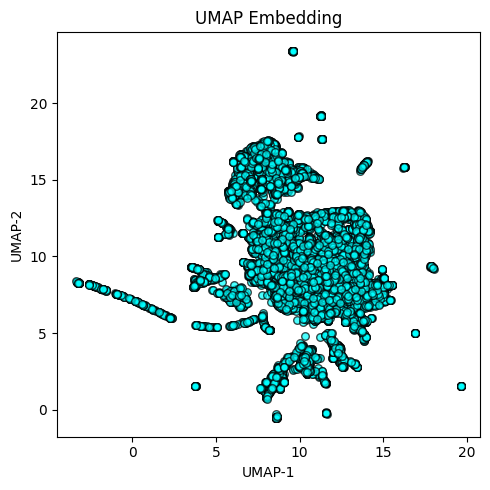

In [6]:
NeighbourSearch.plot_embedding()

Example Usage:

In [7]:
# This will return the 5 nearest neighbours to BODPAN that have a reported water stability value, we will alsop attach the water stability value to the neighbours
Neighbours = NeighbourSearch.find_neighbours('BODPAN', method='umap', subset=ws_data['m.refcode'], label_df=ws_data, label_column='water_stability')
Neighbours

,m.refcode,"Chemical Embedding Distance to ""BODPAN""",water_stability
0,MAWFEY,0.431341,Stable
1,ZUCKIT,0.508795,Unstable
2,DAWCIP,0.517196,Stable
3,MOCKAR,0.585196,Unstable
4,UBIPAY,0.603004,Stable


## Prepare Test Train Split

In [8]:
import numpy as np
array = np.load('Benchmarks/ws_test_set.npy')
test_set = pd.DataFrame(array)

In [9]:
# Rename the column in test_set to match the column name in MOFid for merging
test_set.columns = ['m.refcode']

# Merge test_set with MOFid to add MOFid values
test_set = test_set.merge(ws_data, on='m.refcode', how='left')

# Clean the MOFid column to remove anything after a space
test_set['MOFid'] = test_set['MOFid'].str.split(' ').str[0]

test_set

,m.refcode,water_stability,MOFid
0,DUGBAJ,Stable,[Fe].[O-]C(=O)c1cccc(n1)C(=O)[O-].[Tb]
1,EDAWUE,Unstable,[Cu].[O-]C(=O)C1CCCN(C1)CP(=O)(O)[O].[O-]C(=O)...
2,IBOQAU,Stable,C(=Cc1ccncc1)C=Cc1ccncc1.[Cd].[O-]C(=O)c1cc(cc...
3,XIHWUI,Unstable,O=C1CCCN1C.[Mn].[O-]C(=O)c1cc(c2ccc(cc2)C(=O)[...
4,EJAXIW,Unstable,[Co].[O]S(=O)(=O)[O].n1ccc(cc1)CCc1ccncc1
...,...,...,...
317,KEHVAX,Stable,[O-]C(=O)c1ccc(o1)c1ccc(o1)C(=O)[O-].[OH2][Zn]...
318,WIKLOT,Unstable,[O]P(=O)(CCP(=O)(O)[O])O.[U]
319,LIXZAW,Stable,[Co].[O-]C(=O)c1ccc2c(c1)c1cc(ccc1n2Cc1ccc(cc1...
320,IBICAZ,Stable,CC(C(C(=O)[O-])NCc1ccncc1)C.Cl[Zn]


## LLM Predictions

In [25]:
import os
import openai
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

# --- Step 1: Setup ---
openai.api_key = os.environ["OPENAI_API_KEY"]
MODEL_NAME = "gpt-4o"

llm_predictions = {
    'Blind': [],
    'Graph-Enhanced': []
}
prompts = {
    'Blind': [],
    'Graph-Enhanced': []
}

# --- Step 2: Prompt templates ---
def prompt_blind(mofid):
    return f"""Is the MOF with ID "{mofid}" water stable or unstable? 
Answer with only one word: "Stable" or "Unstable"."""

def prompt_graph_enhanced(refcode, neighbors_df):
    lines = [
        f"- {row['m.refcode']} ({row['water_stability']}, {row[f'Chemical Embedding Distance to \"{refcode}\"']:.3f} distance)"
        for _, row in neighbors_df.iterrows()
    ]
    return f"""The MOF with refcode {refcode} has the following nearby MOFs in the UMAP embedding space:

{chr(10).join(lines)}

Based on this information, is {refcode} water stable or unstable?
Answer with only one word: "Stable" or "Unstable"."""

# --- Step 3: Build prompts ---
for idx, row in test_set.iterrows():
    refcode = row["m.refcode"] 
    mofid = row["MOFid"]

    # Blind prompt
    prompts["Blind"].append(prompt_blind(mofid))

    # Neighbors for graph-enhanced prompt
    neighbors = NeighbourSearch.find_neighbours(
        target_refcode=refcode,
        method="umap",
        subset=ws_data["m.refcode"],
        label_df=ws_data,
        label_column="water_stability"
    )

    # Graph-enhanced prompt
    graph_prompt = prompt_graph_enhanced(refcode, neighbors)
    prompts["Graph-Enhanced"].append(graph_prompt)

# --- Step 4: LLM querying ---
def query_llm(prompt):
    response = openai.chat.completions.create(
        model=MODEL_NAME,
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    return response.choices[0].message.content.strip()

def query_many(prompts_list):
    results = []
    with ThreadPoolExecutor(max_workers=50) as executor:
        futures = [executor.submit(query_llm, p) for p in prompts_list]
        for future in as_completed(futures):
            results.append(future.result())
    return results

# --- Step 5: Run predictions ---
for model_name in prompts:
    print(f"🔮 Running parallel queries for {model_name}...")
    llm_predictions[model_name] = query_many(prompts[model_name])

# --- Step 6: Accuracy and save ---
def accuracy(preds, ground_truths):
    correct = 0
    for p, gt in zip(preds, ground_truths):
        if p.lower().strip() == gt:
            correct += 1
    return correct / len(ground_truths)

ground_truths = test_set['water_stability'].str.lower().tolist()

print("\n📊 LLM Water Stability Prediction Accuracy:")
for model_name in llm_predictions:
    acc = accuracy(llm_predictions[model_name], ground_truths)
    print(f"{model_name:>15}: {acc:.2%}")

# Attach predictions to DataFrame
test_set["Blind Prediction"] = llm_predictions["Blind"]
test_set["Graph-Enhanced Prediction"] = llm_predictions["Graph-Enhanced"]

# Save
test_set.to_csv("llm_graph_prediction_results.csv", index=False)
print("\n✅ Saved to 'llm_graph_prediction_results.csv'")


🔮 Running parallel queries for Blind...
🔮 Running parallel queries for Graph-Enhanced...

📊 LLM Water Stability Prediction Accuracy:
          Blind: 33.23%
 Graph-Enhanced: 52.80%

✅ Saved to 'llm_graph_prediction_results.csv'
